In [28]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif,f_classif
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn import tree
import dtreeviz
from sklearn.utils import resample
np.set_printoptions(threshold=np.inf)
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [29]:
radiomic_features_df = pd.read_table('Data\clinical_radiomics.tsv')
print(radiomic_features_df)

      ID      MIP     sex  age histopathology   type location  T  N  \
0      1  1842722    MALE   81     Large_Cell  NSCLC    RIGHT  3  0   
1      2   596362    MALE   74       SQUAMOUS  NSCLC     LEFT  2  2   
2      3  1650062    MALE   77       SQUAMOUS  NSCLC     LEFT  2  2   
3      4   701827  FEMALE   74       SQUAMOUS  NSCLC    RIGHT  3  2   
4      5  1811403    MALE   78     Large_Cell  NSCLC    RIGHT  3  0   
..   ...      ...     ...  ...            ...    ...      ... .. ..   
126  127   653575  FEMALE   45          ADENO  NSCLC     LEFT  2  2   
127  128  1373477    MALE   46       SQUAMOUS  NSCLC    RIGHT  4  0   
128  129   707208  FEMALE   43     Large_Cell  NSCLC    RIGHT  2  2   
129  130   749310    MALE   43       SQUAMOUS  NSCLC     LEFT  2  2   
130  131  1826730    MALE   46       SQUAMOUS  NSCLC     LEFT  2  2   

     zubrod_score  ...  original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0             1.0  ...                                          12.813

In [30]:
#Clean up
radiomic_features_df = radiomic_features_df[radiomic_features_df.OS_cens == '0']
radiomic_features_df["OS_result"] = radiomic_features_df["OS"] > radiomic_features_df["OS"].median() if 'long' else 'short'
radiomic_features_df = radiomic_features_df.drop(columns=["Image","Mask","type","CT_drugs","Treatment", "intent", "Metastasis_location", 
                                                          "diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy",
                                                          "diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet",
                                                          "diagnostics_Versions_Python","diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes",
                                                          "diagnostics_Image.original_Hash", "diagnostics_Image.original_Dimensionality", "diagnostics_Image.original_Spacing",
                                                          "diagnostics_Image.original_Minimum", "OS_cens","diagnostics_Image.original_Minimum", "OS", "diagnostics_Mask.original_Hash",
                                                          "diagnostics_Mask.original_Spacing", "diagnostics_Mask.original_BoundingBox",	"diagnostics_Mask.original_VoxelNum", "N",
                                                          "diagnostics_Mask.original_Size",  "diagnostics_Image.original_Size", "diagnostics_Mask.original_CenterOfMassIndex",	"diagnostics_Mask.original_CenterOfMass",
                                                          "CT_effect", "zubrod_score", "T", "HT", "PLT", "RBC", "WBC", "ID", "MFS","MFS_cens","CT_cycles", "histopathology", "location",
                                                           "MIP","RT_fractional_dose", "HB"])
#print(radiomic_features_df)
print(radiomic_features_df .isna().sum())

sex                                   0
age                                   0
RT_total_dose                         0
diagnostics_Image.original_Mean       0
diagnostics_Image.original_Maximum    0
                                     ..
original_ngtdm_Coarseness             0
original_ngtdm_Complexity             0
original_ngtdm_Contrast               0
original_ngtdm_Strength               0
OS_result                             0
Length: 112, dtype: int64


1.25724


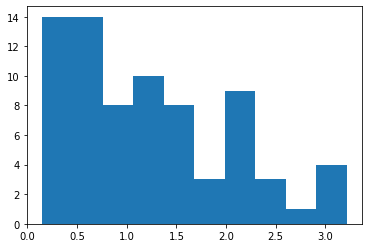

In [23]:
print(radiomic_features_df["OS"].mean())
plt.hist(radiomic_features_df["OS"])
plt.show()

2      False
3      False
9       True
10      True
11     False
       ...  
126    False
127     True
128    False
129    False
130    False
Name: OS_result, Length: 74, dtype: bool


<AxesSubplot:ylabel='Type'>

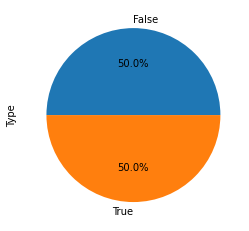

In [31]:
print(radiomic_features_df["OS_result"])

radiomic_features_df.groupby('OS_result').size().plot(kind='pie',
                                       y = "OS_result",
                                       label = "Type",
                                       autopct='%1.1f%%'
                                       )

In [8]:
column_names = radiomic_features_df.columns.values.tolist()
comb = combinations(column_names, 5)


In [ ]:
for i in comb:
    print(i)

In [32]:
X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]    #target column i.e price range

df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(25,'Score'))  #print 10 best features

                                               Specs      Score
27                          original_firstorder_Mean  12.492375
19                  original_firstorder_10Percentile  12.460304
32               original_firstorder_RootMeanSquared  12.372273
28                        original_firstorder_Median  12.156777
20                  original_firstorder_90Percentile  11.889937
25                       original_firstorder_Maximum  11.316411
26         original_firstorder_MeanAbsoluteDeviation   9.738244
30                         original_firstorder_Range   9.715976
23            original_firstorder_InterquartileRange   9.469310
31   original_firstorder_RobustMeanAbsoluteDeviation   9.453929
36                      original_firstorder_Variance   9.055309
2                    diagnostics_Image.original_Mean   7.399045
29                       original_firstorder_Minimum   7.296563
21                        original_firstorder_Energy   5.588167
34                   original_firstorder

c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


C:\Users\Pc\AppData\Local\Temp\ipykernel_16668\1562543965.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[0.00875407 0.00442169 0.02094879 0.0065448  0.00172522 0.01345892
 0.0060599  0.00537623 0.00464152 0.00532521 0.00642208 0.00704419
 0.00635803 0.00811953 0.00501691 0.00952704 0.00580226 0.00909081
 0.00849162 0.01513824 0.02085395 0.00930711 0.01201509 0.01061944
 0.01520768 0.01793261 0.01343931 0.01895237 0.01947823 0.01904358
 0.0174338  0.01036833 0.02254545 0.00724275 0.00715151 0.00671279
 0.01506395 0.01020889 0.00520564 0.00910188 0.00665194 0.00961491
 0.00767823 0.00621073 0.00753254 0.00637494 0.00654625 0.00577504
 0.00674463 0.01119182 0.00984921 0.00926326 0.00876288 0.00719646
 0.01012451 0.00811424 0.00523238 0.01079597 0.00778745 0.00491208
 0.00850996 0.00812103 0.00874026 0.00489585 0.00401374 0.00494725
 0.0118282  0.01215162 0.00659627 0.00938515 0.00987885 0.00687922
 0.01214612 0.00975035 0.0096511  0.00658568 0.01171468 0.00884173
 0.00855469 0.00614422 0.00492553 0.00810589 0.00990838 0.00581179
 0.00685454 0.01034819 0.01091892 0.01285841 0.00520614 0.0046

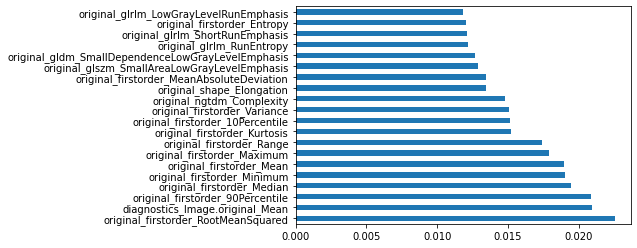

In [33]:

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances.nlargest(20))
plt.show()

original_glszm_HighGrayLevelZoneEmphasis              0.243910
original_glszm_SmallAreaHighGrayLevelEmphasis         0.231002
original_glszm_ZonePercentage                         0.189650
original_shape_SurfaceVolumeRatio                     0.188537
original_ngtdm_Complexity                             0.175221
original_ngtdm_Strength                               0.169206
original_glcm_Contrast                                0.162912
original_gldm_SmallDependenceEmphasis                 0.161464
original_gldm_SmallDependenceHighGrayLevelEmphasis    0.159146
original_glszm_SizeZoneNonUniformityNormalized        0.158466
original_ngtdm_Coarseness                             0.155384
original_glcm_DifferenceVariance                      0.141368
original_glcm_DifferenceAverage                       0.130218
original_gldm_SmallDependenceLowGrayLevelEmphasis     0.103927
original_ngtdm_Contrast                               0.101337
original_glrlm_ShortRunHighGrayLevelEmphasis          0

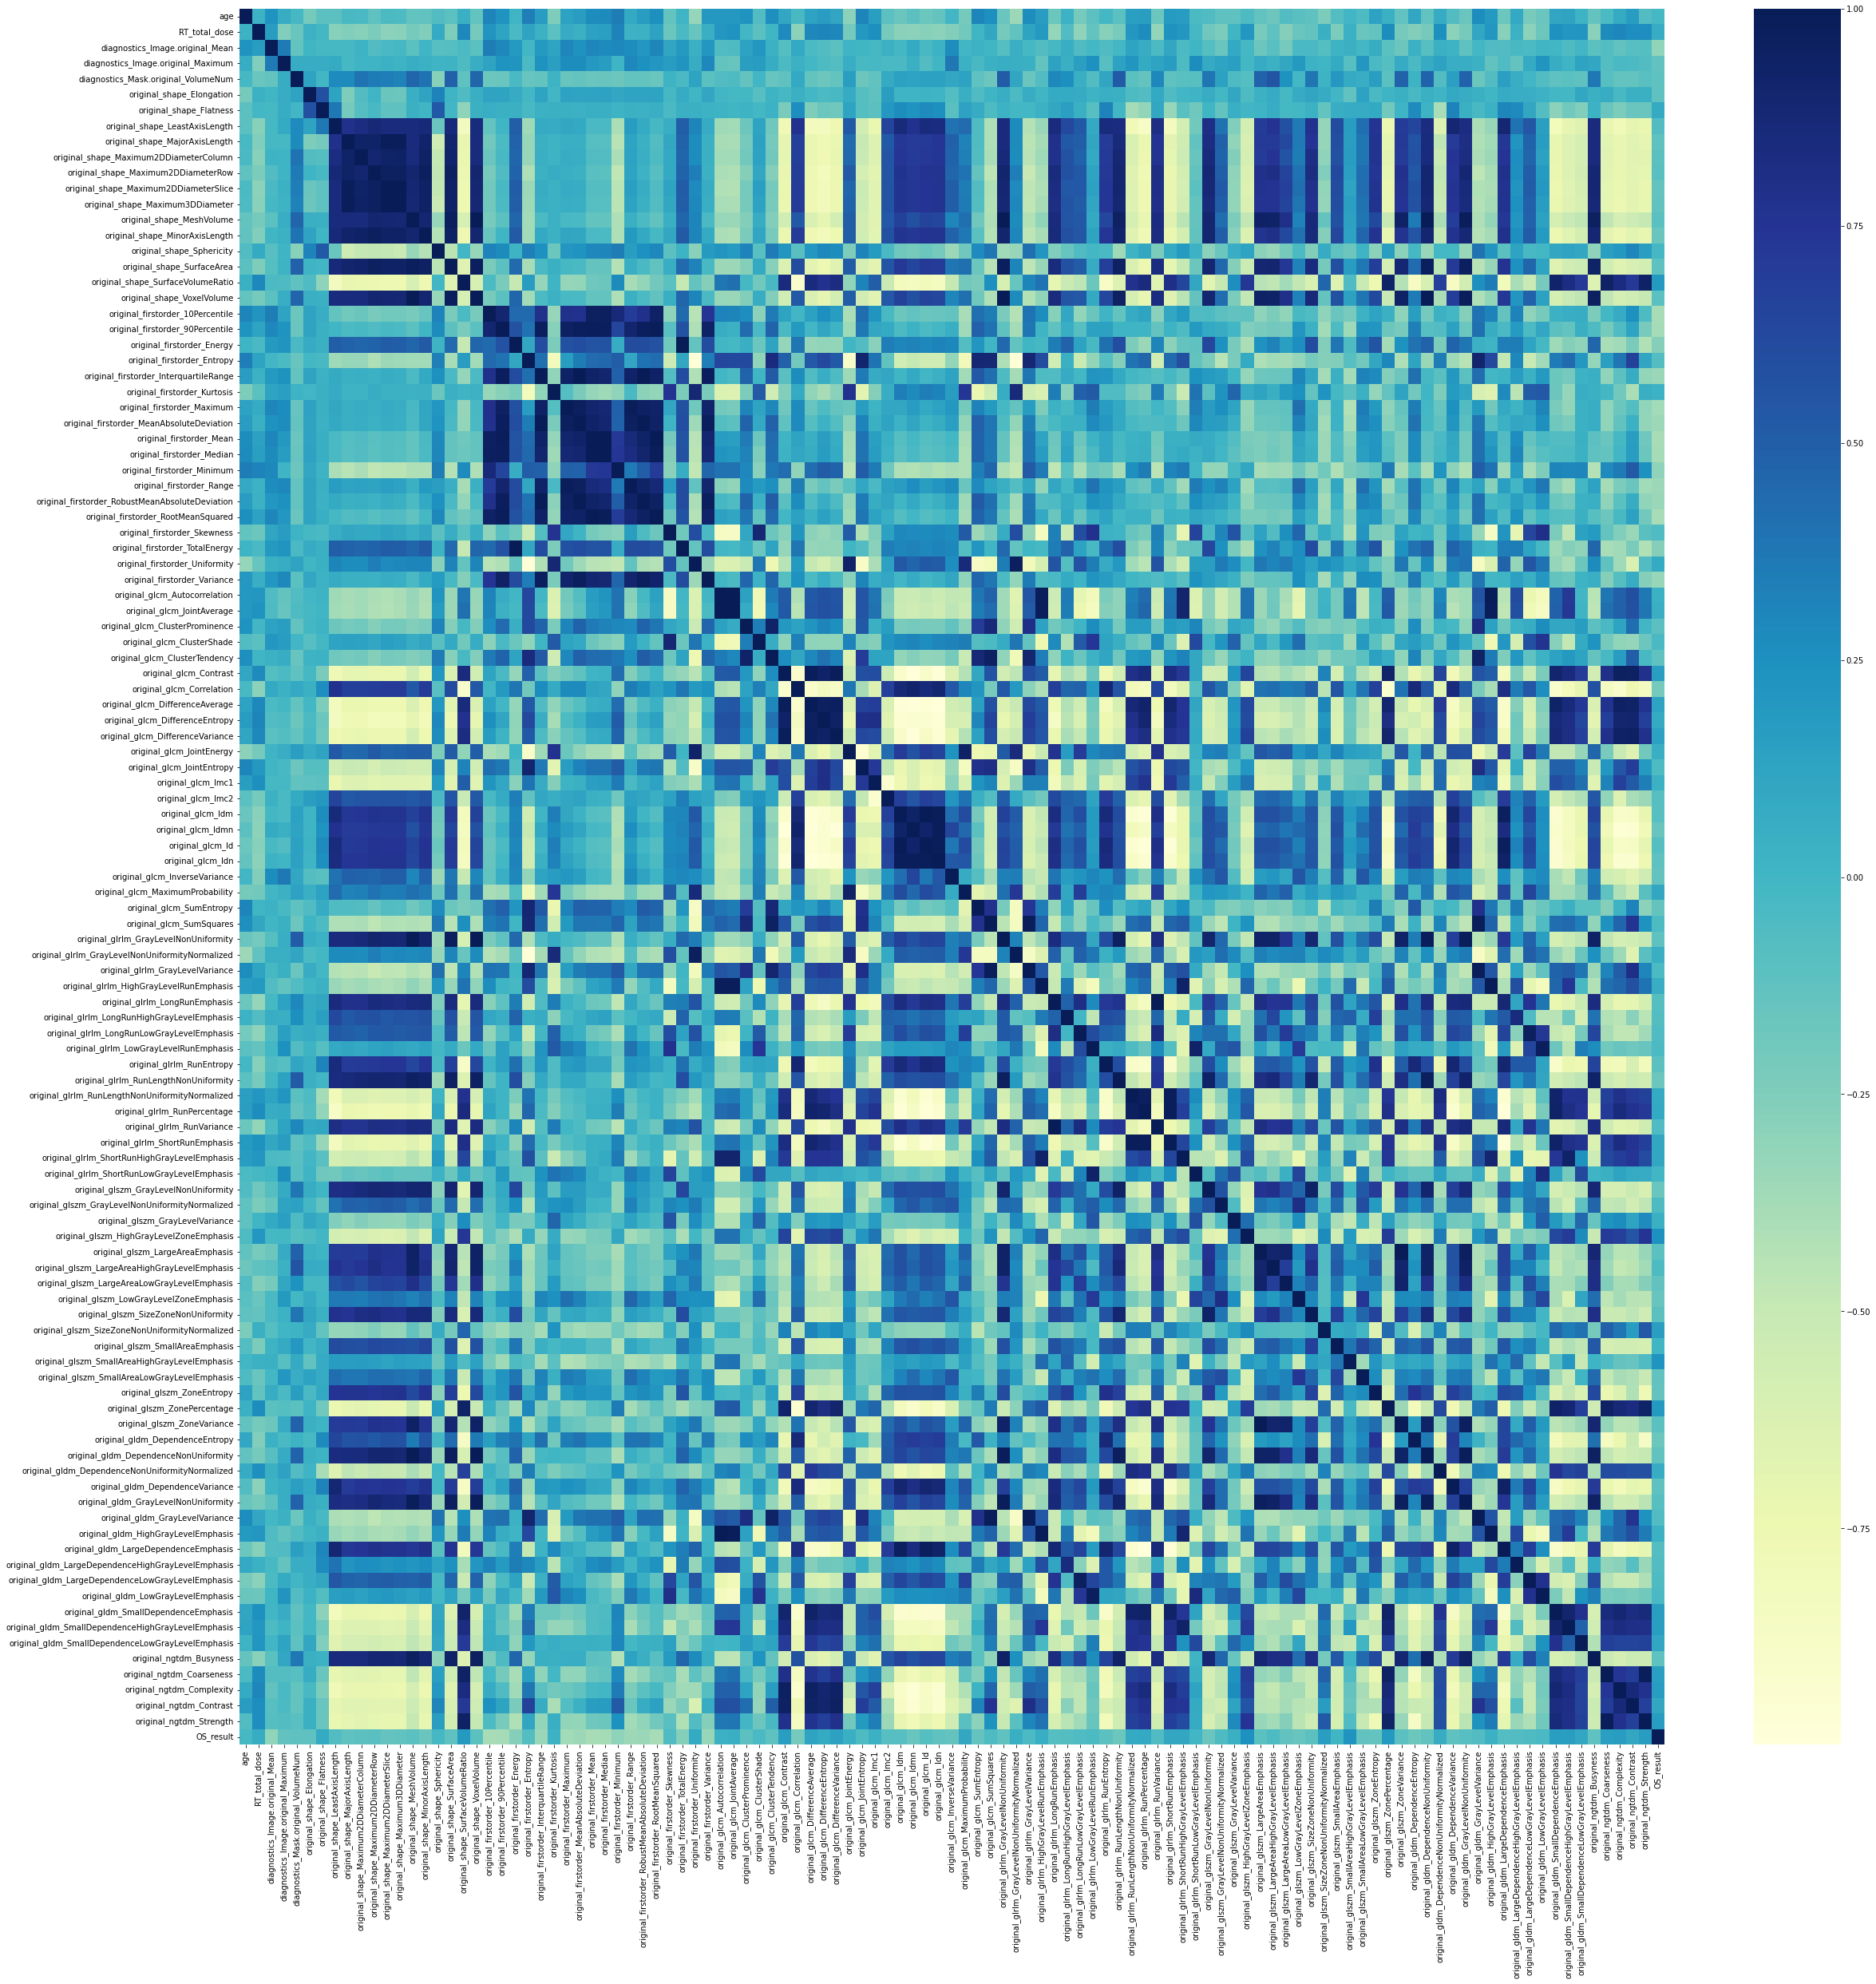

In [34]:
corrmat = radiomic_features_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,40))
#plot heat map
g=sns.heatmap(radiomic_features_df[top_corr_features].corr(),cmap="YlGnBu")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(radiomic_features_df[top_corr_features].corr()['OS_result'][:-1].sort_values(ascending=False))


0.6628571428571429 {'criterion': 'gini', 'random_state': 18}


c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


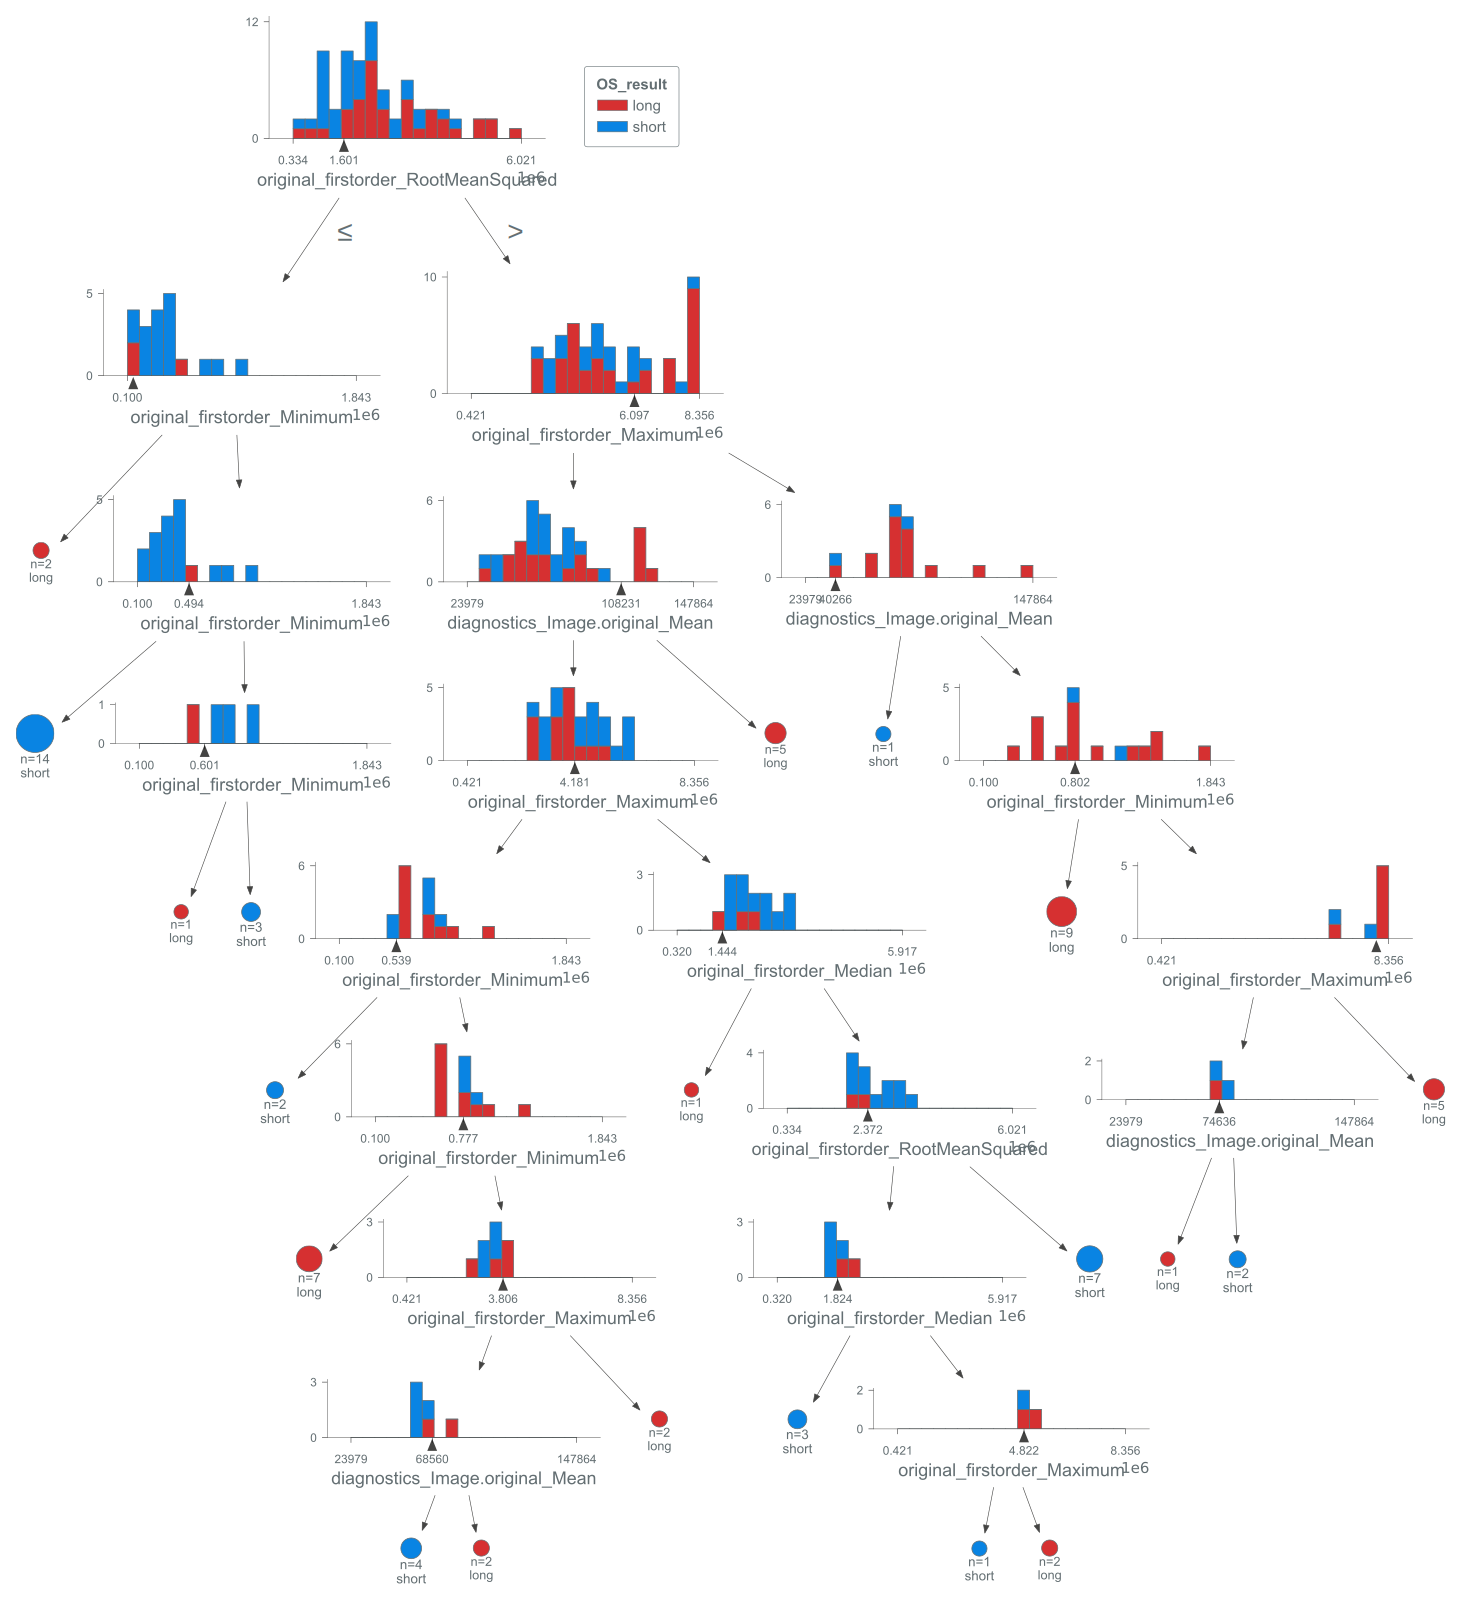

In [47]:
classes = ["original_firstorder_RootMeanSquared", "diagnostics_Image.original_Mean","original_firstorder_Median","original_firstorder_Minimum","original_firstorder_Mean","original_firstorder_Maximum" ]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = DecisionTreeClassifier()
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18, 33, 69]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
viz = dtreeviz.model(tree_model, X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
viz.view(
    colors={'classes': [
    None,  # 0 classes
    None,  # 1 class
    ['#d63031', '#0984e3'],  # 2 classes
],

              'split_line': '#636e72',
              'axis_label': '#636e72',
              'title': '#636e72',
              'legend_title': '#636e72',
              'legend_edge': '#636e72',
              'edge': '#636e72',
              'rect_edge': '#636e72',
              'text': '#636e72',
              'arrow': '#636e72',
              'node_label': '#636e72',
              'tick_label': '#636e72',
              'leaf_label': '#636e72',
              'pie': '#636e72',
},
    fancy=True,
    scale=2)

0.718095238095238 {'criterion': 'entropy', 'random_state': 33}


c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


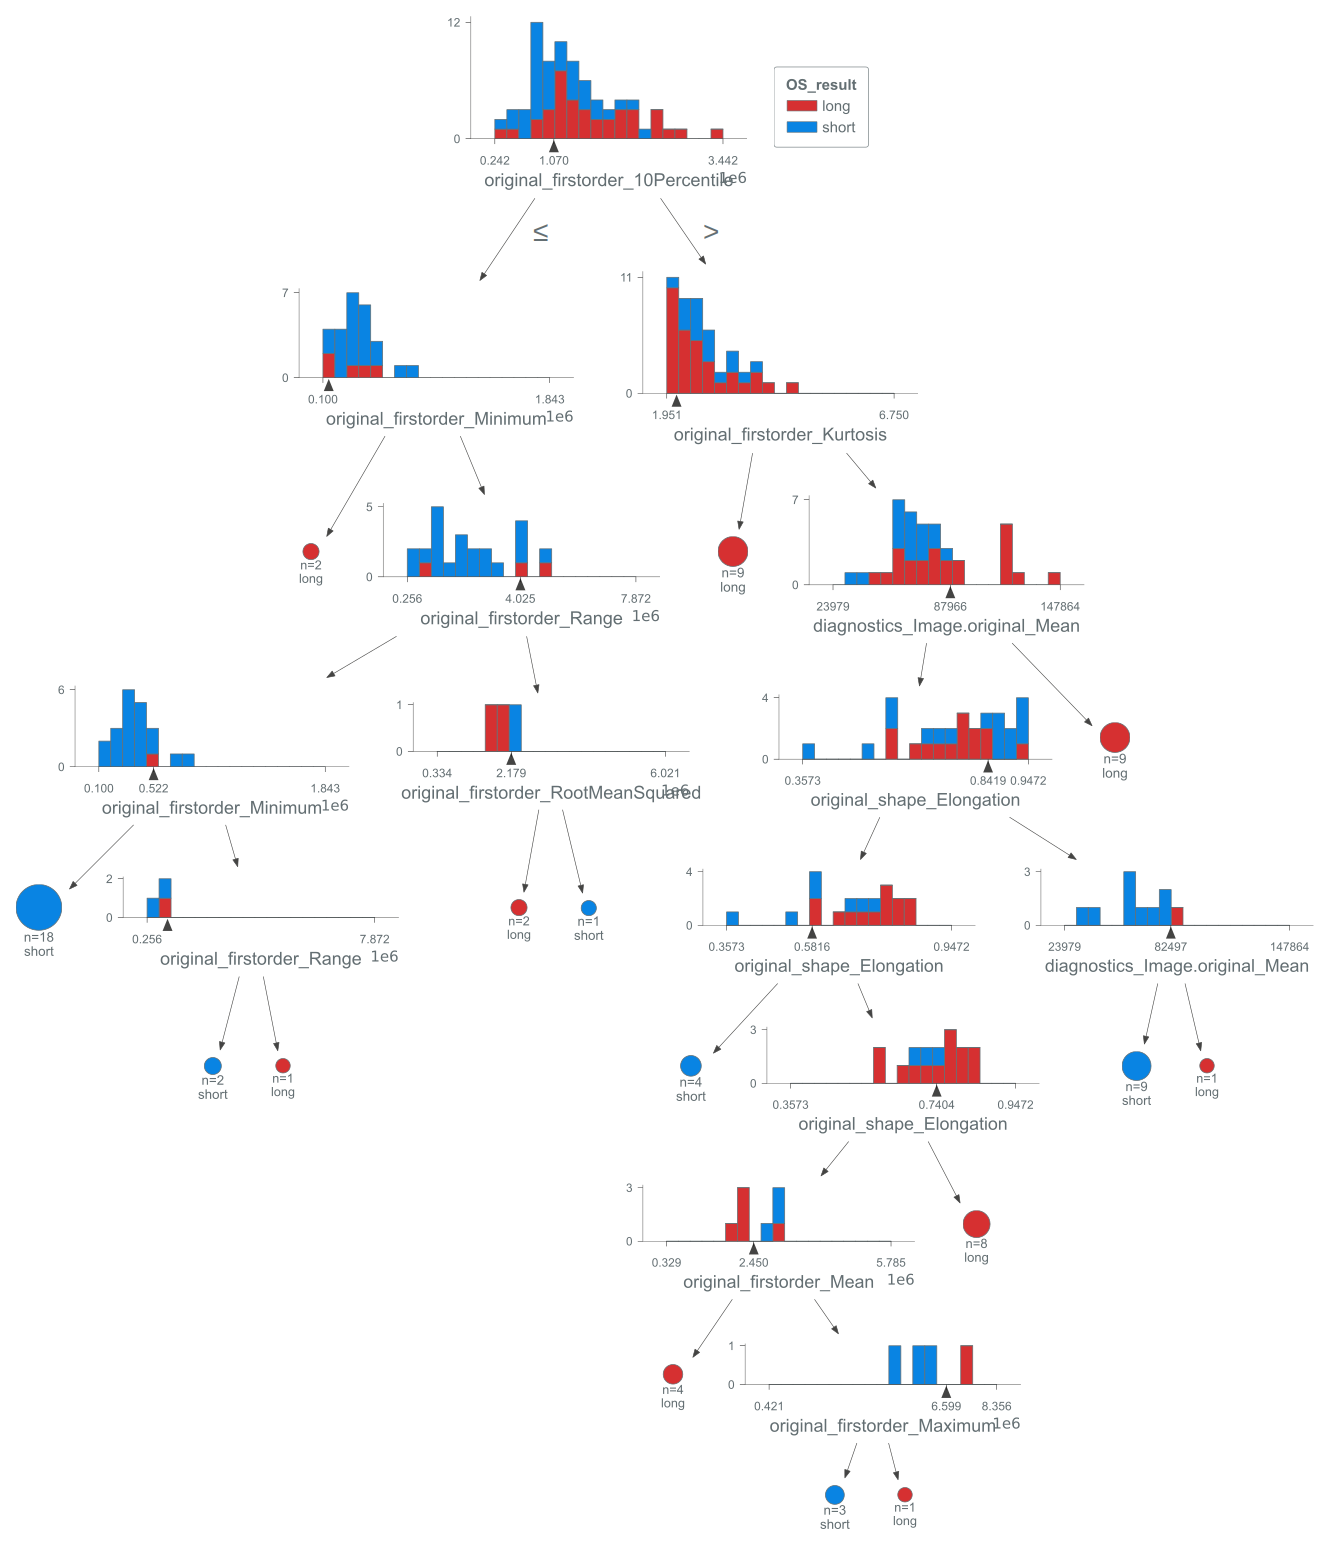

In [48]:
classes = ["original_firstorder_RootMeanSquared", "diagnostics_Image.original_Mean","original_firstorder_Median","original_firstorder_Minimum","original_firstorder_Mean","original_firstorder_Maximum",
            "original_firstorder_Range","original_firstorder_Kurtosis","original_firstorder_10Percentile","original_firstorder_Variance","original_ngtdm_Complexity","original_shape_Elongation"]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = DecisionTreeClassifier()
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18, 33, 69]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
viz = dtreeviz.model(tree_model, X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
viz.view(
    colors={'classes': [
    None,  # 0 classes
    None,  # 1 class
    ['#d63031', '#0984e3'],  # 2 classes
],

              'split_line': '#636e72',
              'axis_label': '#636e72',
              'title': '#636e72',
              'legend_title': '#636e72',
              'legend_edge': '#636e72',
              'edge': '#636e72',
              'rect_edge': '#636e72',
              'text': '#636e72',
              'arrow': '#636e72',
              'node_label': '#636e72',
              'tick_label': '#636e72',
              'leaf_label': '#636e72',
              'pie': '#636e72',
},
    fancy=True,
    scale=2)

0.6742857142857142 {'criterion': 'gini', 'random_state': 18}


c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


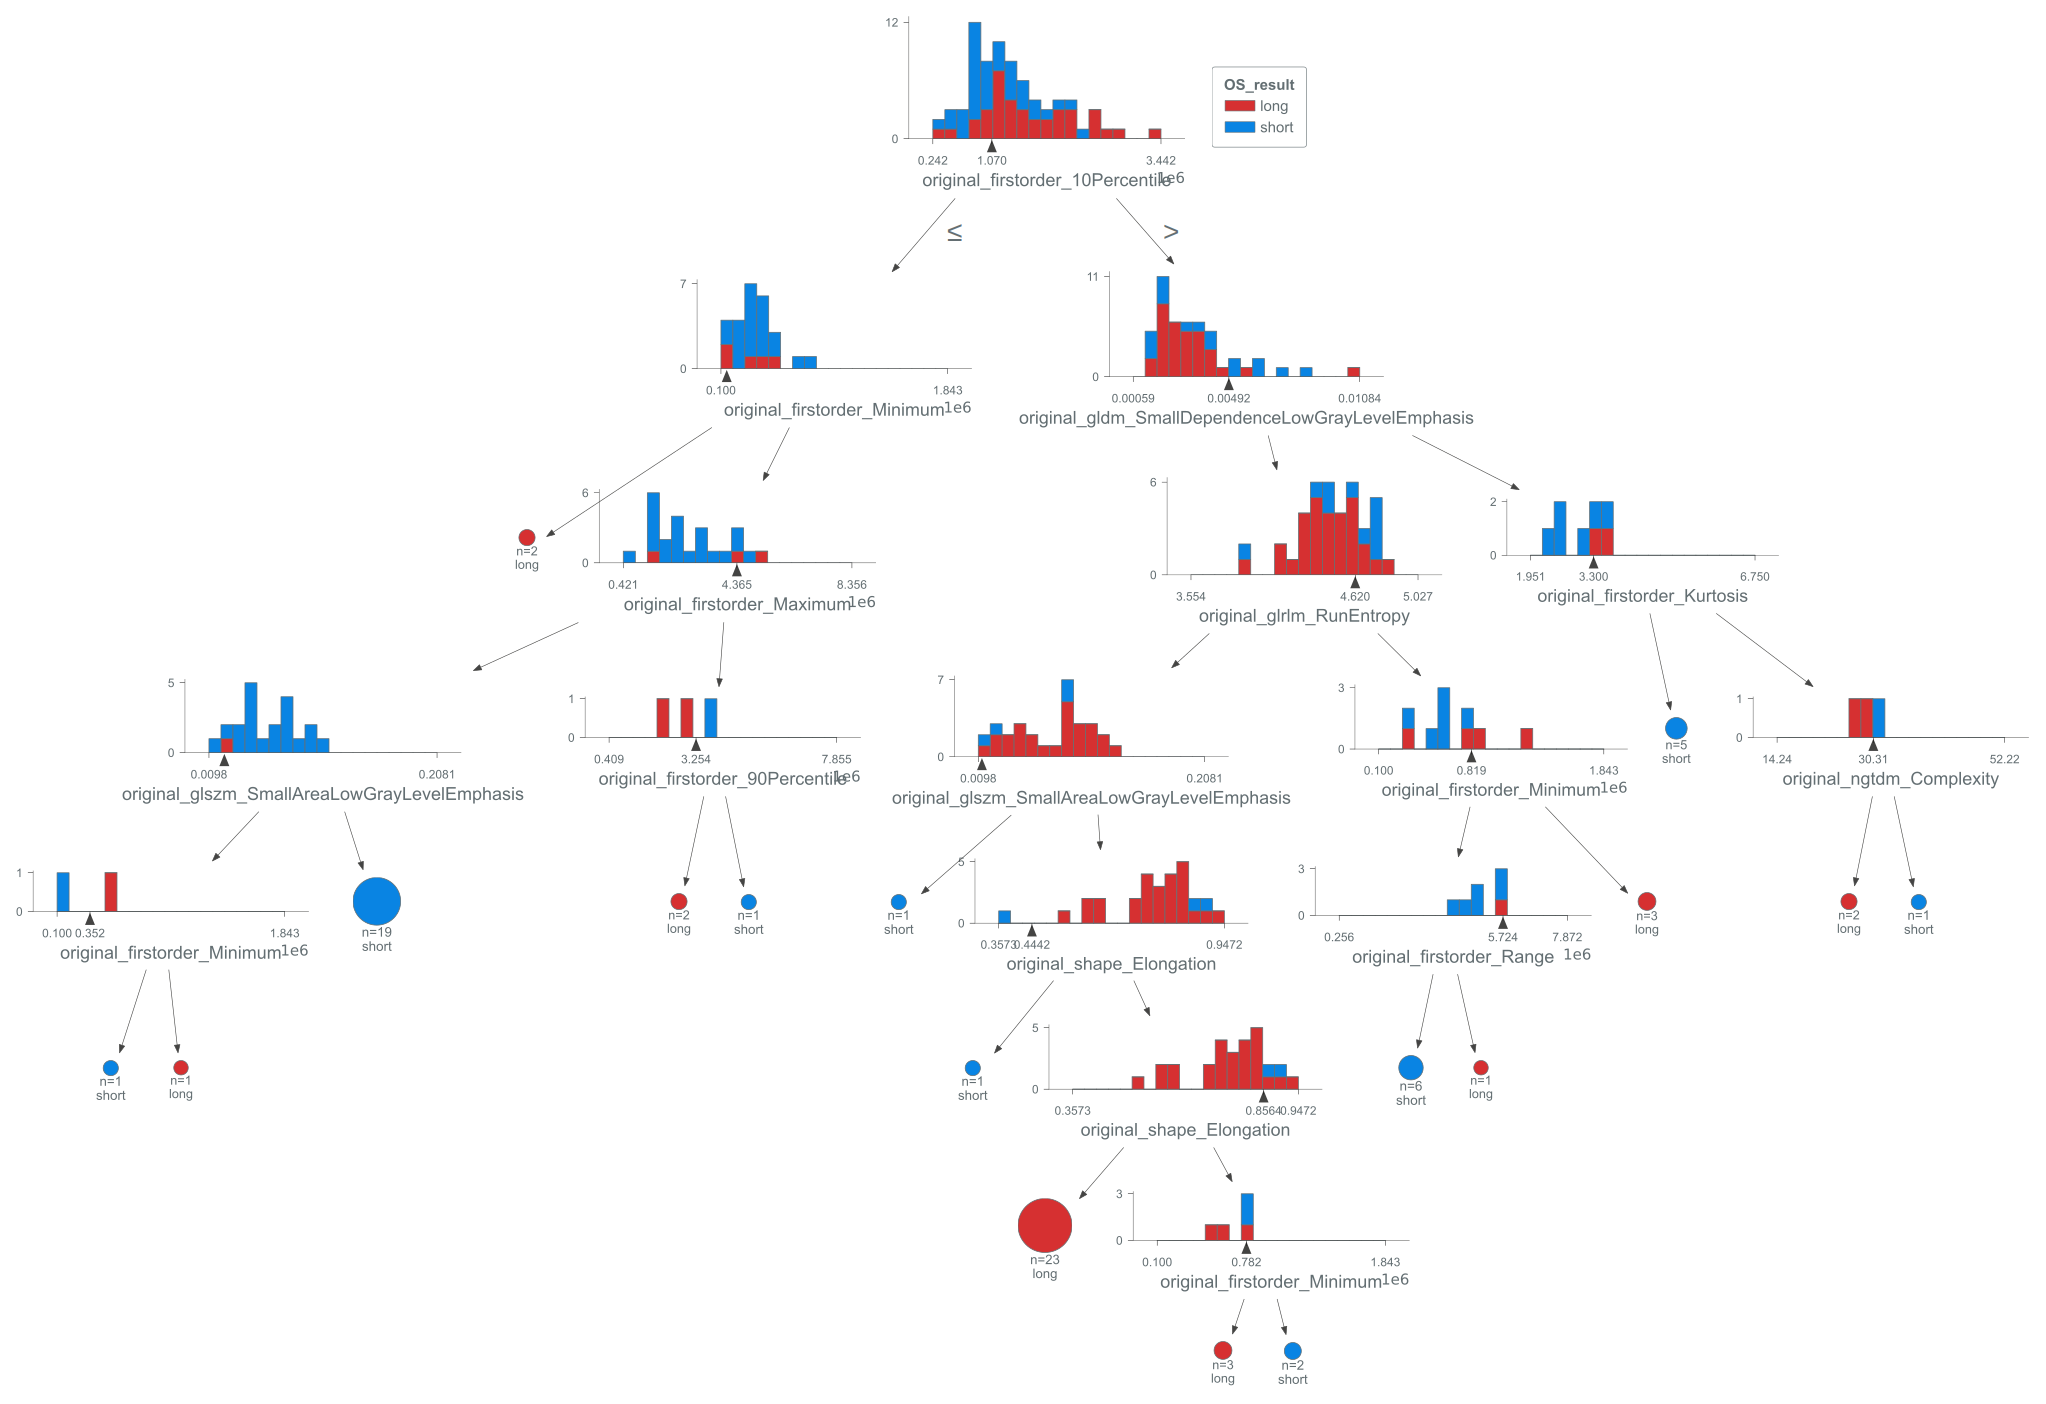

In [57]:
classes = ["original_firstorder_RootMeanSquared", "diagnostics_Image.original_Mean","original_firstorder_Median","original_firstorder_Minimum","original_firstorder_Mean","original_firstorder_Maximum",
            "original_firstorder_Range","original_firstorder_Kurtosis","original_firstorder_10Percentile","original_firstorder_Variance","original_ngtdm_Complexity","original_shape_Elongation",
            "original_glrlm_RunEntropy", "original_firstorder_90Percentile","original_firstorder_MeanAbsoluteDeviation","original_glszm_SmallAreaLowGrayLevelEmphasis","original_gldm_SmallDependenceLowGrayLevelEmphasis"  ]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = DecisionTreeClassifier()
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18,33,69]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
viz = dtreeviz.model(tree_model, X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
viz.view(
    colors={'classes': [
    None,  # 0 classes
    None,  # 1 class
    ['#d63031', '#0984e3'],  # 2 classes
],

              'split_line': '#636e72',
              'axis_label': '#636e72',
              'title': '#636e72',
              'legend_title': '#636e72',
              'legend_edge': '#636e72',
              'edge': '#636e72',
              'rect_edge': '#636e72',
              'text': '#636e72',
              'arrow': '#636e72',
              'node_label': '#636e72',
              'tick_label': '#636e72',
              'leaf_label': '#636e72',
              'pie': '#636e72',
},
    fancy=True,
    scale=2)

In [56]:
classes = ["original_firstorder_RootMeanSquared", "diagnostics_Image.original_Mean","original_firstorder_Median","original_firstorder_Minimum","original_firstorder_Mean","original_firstorder_Maximum" ]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = RandomForestClassifier(10)
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18,33,59]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
# for i in range(9):
#     viz = dtreeviz.model(tree_model.estimators_[i], X, y,
#                 target_name="OS_result",
#                 feature_names=classes,
#                 class_names=["long", "short"])
#     viz.view(
#         colors={'classes': [
#         None,  # 0 classes
#         None,  # 1 class
#         ['#d63031', '#0984e3'],  # 2 classes
#     ],

#                   'split_line': '#636e72',
#                   'axis_label': '#636e72',
#                   'title': '#636e72',
#                   'legend_title': '#636e72',
#                   'legend_edge': '#636e72',
#                   'edge': '#636e72',
#                   'rect_edge': '#636e72',
#                   'text': '#636e72',
#                   'arrow': '#636e72',
#                   'node_label': '#636e72',
#                   'tick_label': '#636e72',
#                   'leaf_label': '#636e72',
#                   'pie': '#636e72',
#     },
#         fancy=True,
#         scale=2)
    

0.6771428571428572 {'criterion': 'entropy', 'random_state': 18}


In [55]:
classes = ["original_firstorder_RootMeanSquared", "diagnostics_Image.original_Mean","original_firstorder_Median","original_firstorder_Minimum","original_firstorder_Mean","original_firstorder_Maximum",
            "original_firstorder_Range","original_firstorder_Kurtosis","original_firstorder_10Percentile","original_firstorder_Variance","original_ngtdm_Complexity","original_shape_Elongation"]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = RandomForestClassifier(10)
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18,33 ,69]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
# for i in range(9):
#     viz = dtreeviz.model(tree_model.estimators_[i], X, y,
#                 target_name="OS_result",
#                 feature_names=classes,
#                 class_names=["long", "short"])
#     viz.view(
#         colors={'classes': [
#         None,  # 0 classes
#         None,  # 1 class
#         ['#d63031', '#0984e3'],  # 2 classes
#     ],

#                   'split_line': '#636e72',
#                   'axis_label': '#636e72',
#                   'title': '#636e72',
#                   'legend_title': '#636e72',
#                   'legend_edge': '#636e72',
#                   'edge': '#636e72',
#                   'rect_edge': '#636e72',
#                   'text': '#636e72',
#                   'arrow': '#636e72',
#                   'node_label': '#636e72',
#                   'tick_label': '#636e72',
#                   'leaf_label': '#636e72',
#                   'pie': '#636e72',
#     },
#         fancy=True,
#         scale=2)
    

0.6514285714285715 {'criterion': 'entropy', 'random_state': 69}


In [63]:
classes = ["original_firstorder_RootMeanSquared", "diagnostics_Image.original_Mean","original_firstorder_Median","original_firstorder_Minimum","original_firstorder_Mean","original_firstorder_Maximum",
            "original_firstorder_Range","original_firstorder_Kurtosis","original_firstorder_10Percentile","original_firstorder_Variance","original_ngtdm_Complexity","original_shape_Elongation",
            "original_glrlm_RunEntropy", "original_firstorder_90Percentile","original_firstorder_MeanAbsoluteDeviation","original_glszm_SmallAreaLowGrayLevelEmphasis","original_gldm_SmallDependenceLowGrayLevelEmphasis"  ]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = RandomForestClassifier(10)
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18,33,69]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
for i in range(9):
    viz = dtreeviz.model(tree_model.estimators_[i], X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
    v =viz.view(
        colors={'classes': [
        None,  # 0 classes
        None,  # 1 class
        ['#d63031', '#0984e3'],  # 2 classes
    ],

                  'split_line': '#636e72',
                  'axis_label': '#636e72',
                  'title': '#636e72',
                  'legend_title': '#636e72',
                  'legend_edge': '#636e72',
                  'edge': '#636e72',
                  'rect_edge': '#636e72',
                  'text': '#636e72',
                  'arrow': '#636e72',
                  'node_label': '#636e72',
                  'tick_label': '#636e72',
                  'leaf_label': '#636e72',
                  'pie': '#636e72',
    },
        fancy=True,
        scale=2)
    v.show() 
    #print(viz.explain_prediction_path(X.iloc[1]))

0.6904761904761905 {'criterion': 'gini', 'random_state': 33}
